Type of pkts var:  <class 'scapy.plist.PacketList'>
Sniffed packets:  <temp.pcap: TCP:4 UDP:6 ICMP:0 Other:0>
Summary of the first packet:  Ether / IP / UDP 212.50.71.179:39678 > 147.32.84.229:13363
###[ IP ]### 
  version   = 4
  ihl       = 5
  tos       = 0x0
  len       = 60
  id        = 62493
  flags     = 
  frag      = 0
  ttl       = 117
  proto     = udp
  chksum    = 0x4da8
  src       = 212.50.71.179
  dst       = 147.32.84.229
  \options   \
###[ UDP ]### 
     sport     = 39678
     dport     = 13363
     len       = 40
     chksum    = 0xc523

Payload details of first packet:  None
Overview of all IP pkts:  <IP from temp.pcap: TCP:4 UDP:6 ICMP:0 Other:0>
IP fields:  ['version', 'ihl', 'tos', 'len', 'id', 'flags', 'frag', 'ttl', 'proto', 'chksum', 'src', 'dst', 'options']
TCP fields:  ['sport', 'dport', 'seq', 'ack', 'dataofs', 'reserved', 'flags', 'window', 'chksum', 'urgptr', 'options']
All fields:  ['version', 'ihl', 'tos', 'len', 'id', 'flags', 'frag', 'ttl', 'proto',

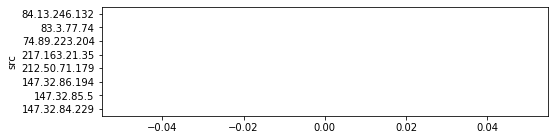

In [3]:
from scapy.all import * 
from scapy.layers.l2 import Ether
from scapy.layers.inet import IP
from scapy.layers.inet import TCP, UDP
import pandas as pd
import matplotlib.pyplot as plt

#preliminary operations
pkts = sniff(offline="/home/davide/Documents/ntac/project/network_traffic.pcap", count = 10) #sniffs 10 pkts from source dataset
print("Type of pkts var: ", type(pkts))
if pkts:
    wrpcap("temp.pcap", pkts) #saves the sniffed pakets in another pcap file
pkts = rdpcap("temp.pcap") #reading and parsing pakets into memory from temp.pcap 
print("Sniffed packets: ", pkts) #printing sniffed packets

#obtaining details on packets
print("Summary of the first packet: ", pkts[0].summary())	#summary of the first packet
print("Payload details of first packet: ", pkts[0].payload.show()) #payload details

#using dataframes for data analysis 
print("Overview of all IP pkts: ", pkts[IP]) #overview of all IP pkts
f_ip = [field.name for field in IP().fields_desc]	#aggregation of field names predefined in the considered layers (IP, TCP)
f_tcp = [field.name for field in TCP().fields_desc]
print("IP fields: ", f_ip)
print("TCP fields: ", f_tcp)
f_all = f_ip + ['time'] + f_tcp + ['payload']
print("All fields: ", f_all)
#dataframes and data structures
df = pd.DataFrame(columns = f_all)
for packet in pkts[IP]:
	field_values = []  #initialization of variable used for storing data in df rows
	for field in f_ip:	#storage of values of IP fields
		if field == 'options':
			field_values.append(len(packet[IP].fields[field]))  #options field is an exception from the other fields: i'm storing only the number of options defined in IP header
		else:
			field_values.append(packet[IP].fields[field]) #adding fied data to df rows
	field_values.append(packet.time)  #adding time data to df rows
	#reading vaues of TCP fields
	layer_type = type(packet[IP].payload)  #var used to select the packet in the next instructions
	for field in f_tcp:
		try:
			if field == 'options':
				field_values.append(len(packet[layer_type].fields[field]))
			else:
				field_values.append(packet[layer_type].fields[field])
		except:
			field_values.append(None)    #if field value does not exist
	field_values.append(len(packet[layer_type].payload)) #reading the values in payload
	df_append = pd.DataFrame([field_values], columns=f_all) #filling the data of one dataframe row in a temp variable for append/concat operation
	df = pd.concat([df, df_append], axis=0) #actually adding the row to the dataframe
#resetting index
df = df.reset_index()
df = df.drop(columns = "index")
#print shape data of the table (rowxcol)
print("Shape: ", df.shape, '\n')
#print first row
print(df.iloc[0], '\n')
#print table with specified fields
print(df[['time', 'src', 'dst', 'sport', 'dport']])

#statistics
print(df['src'].describe(), '\n')	#gives a description of the source addresses
print(df['src'].describe()['top'])	#top ip address 
print(df['src'].unique())		#unique address

src_addr = df.groupby("src")['payload'].sum()	#show the sum of payload for each src ip
print(type(src_addr))
src_addr.plot(kind='barh', figsize=(8,2)) 	#plot figure
plt.show()